# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

Построим модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением *accuracy*.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

## Откроем и изучим файл

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


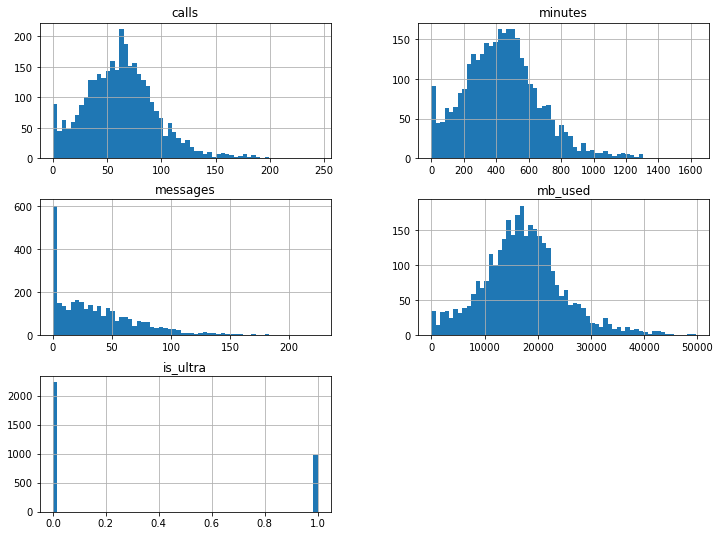

In [5]:
df.hist(bins = 60, figsize = (12, 9))
plt.show()

In [6]:
print('Процент абонентов на тарифе "Ультра":', df.is_ultra.mean() * 100)

Процент абонентов на тарифе "Ультра": 30.647168637212197


Пропуски в данных отсутствуют, выбросы / аномалии отсутсвуют, предобработка не требуется, переходим к исследованию.

## Разобьем данные на выборки

Нас интересуют обучающая, валидационная и тестовая выборки. Чтобы разбить исходный датафрейм в пропорциях 60 : 20 : 20 применим функцию train_test_split(), выделив 20% данных для тестовой выборки, и повторно применим train_test_split() к оставшимся 80% исходных данных, чтобы разделить их на обучающую и валидационную выборки.

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 12345)

In [8]:
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state = 12345)

Далее для каждой из трех получившихся выше выборок выделим из признаков целевой признак (колонку "is_ultra").

In [9]:
train_features = df_train.drop(['is_ultra'], axis=1)
train_target = df_train['is_ultra']

In [10]:
valid_features = df_valid.drop(['is_ultra'], axis=1)
valid_target = df_valid['is_ultra']

In [11]:
test_features = df_test.drop(['is_ultra'], axis=1)
test_target = df_test['is_ultra']

Сравним размеры получившихся переменных.

In [12]:
print(train_features.shape)
print(train_target.shape)
print(valid_features.shape)
print(valid_target.shape)
print(test_features.shape)
print(test_target.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


Разделение прошло корректно, переходим к сравнению моделей.

## Исследуем модели

Целевой признак является бинарным категориальным, соответственно, решаем задачу бинарной классификации.

Применим DecisionTreeClassifier, RandomForestClassifier и LogisticRegression.

Для каждой модели проведем небольшую оптимизацию значений гиперпараметров с целью максимизации метрики качества Accuracy.

Далее сравним максимальные Accuracy трех моделей между собой и подведем промежуточный итог.

Для модели DecisionTreeClassifier ниже подберем максимальную глубину дерева в диапазоне от 1 до 10. Выведем Accuracy и Max depth (глубину дерева) лучшей модели. Запомним результат.

In [13]:
best_result = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth, class_weight='balanced')
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    result = accuracy_score(valid_target, predictions)
    if result > best_result:
        best_result = result
        best_depth = depth
        
print("Accuracy:", best_result, 'Max debth:', best_depth)

Accuracy: 0.7651632970451011 Max debth: 3


Для модели RandomForestClassifier подберем количество деревьев в диапазоне от 40 до 120 (с шагом 10) и максимальную глубину дерева в диапазоне от 1 до 10. Выведем Accuracy, Est (количество деревьев) и Max depth (глубину дерева) лучшей модели. Запомним результат.

In [14]:
best_result = 0
best_est = 0
best_depth = 0
for est in range(40, 121, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, 
                                       max_depth = depth, class_weight='balanced')
        model.fit(train_features, train_target)
        result = model.score(valid_features, valid_target)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy:", best_result, "Est:", best_est, "Max depth:", best_depth)

Accuracy: 0.8009331259720062 Est: 40 Max depth: 9


Для модели LogisticRegression подберем максимальное количество итераций в диапазоне от 100 до 1000 с шагом 10. Выведем Accuracy, Max iter (количество итераций) лучшей модели. Запомним результат.

In [15]:
best_result = 0
best_iter = 0
for iter_ in range(100, 1000, 10):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter = iter_, class_weight='balanced')
    model.fit(train_features, train_target)
    result = model.score(valid_features, valid_target)
    if result > best_result:
        best_result = result
        best_iter = iter_

print("Accuracy:", best_result, "Max iter:", best_iter)

Accuracy: 0.39813374805598756 Max iter: 100


Максимальный Accuracy 0.8 у модели RandomForestClassifier с количеством деревьев 90 и глубиной 10.

## Проверьте модель на тестовой выборке

Далее проверим точность работы модели с приведенными выше настройками гиперпараметров на тестовой выборке.

In [16]:
features_full_train = pd.concat([train_features, valid_features])
target_full_train = pd.concat([train_target, valid_target])

In [17]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 90, max_depth = 10, class_weight='balanced')
model.fit(features_full_train, target_full_train)
result = model.score(test_features, test_target)

print("Accuracy:", result)

Accuracy: 0.7822706065318819


Точность примерно соответствует полученной на тестовой и валидационной выборке. С точки зрения стабильности результата модель работает. Ниже остается провести проверку на "адекватность".

## Проверим модель на адекватность

Ниже сравним полученные результаты с "глупым" классификатором из библиотеки sklearn.

In [18]:
model = DummyClassifier()
model.fit(train_features, train_target)
result = model.score(test_features, test_target)

print("Accuracy:", result)

Accuracy: 0.6951788491446346


В завершение констатируем, что все не зря, и обученная модель действительно способна предсказывать появление динозавра на Красной площади с точностью выше, чем 50 / 50.

## Вывод

<p>В рамках решения исходной задачи классификации исходный датасет с данными о клиентах был разделен на обучающую, валидационную и тестовую выборки. В качестве целевого признака был выделен параметр is_ultra. На тестовой выборке были обучены три модели - Дерево решений, Случайный лес и Логистическая регрессия. Была проведена оптимизация гиперпараметров. Выбор лучшей модели производился по метрике Accuracy.</p>
<p>В результате проведенного исследования была выбрана модель RandomForestClassifier с наилучшим значением accuracy 0.8, достигнутым при значениях количества деревьев 90 и максимальной глубине дерева 10.</p>
<p>Полученный результат был проверен на тестовой выборке и также сравнен со случайным результатом с применением DummyClassifier. Можем сделать вывод, что модель действительно обучена, на тестовой выборке отклонение значения accuracy несущественное, результат "предсказания" выше случайного.</p>